In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/birdclef-2021/train_soundscape_labels.csv
/kaggle/input/birdclef-2021/sample_submission.csv
/kaggle/input/birdclef-2021/test.csv
/kaggle/input/birdclef-2021/train_metadata.csv
/kaggle/input/birdclef-2021/train_soundscapes/20152_SSW_20170805.ogg
/kaggle/input/birdclef-2021/train_soundscapes/57610_COR_20190904.ogg
/kaggle/input/birdclef-2021/train_soundscapes/7843_SSW_20170325.ogg
/kaggle/input/birdclef-2021/train_soundscapes/42907_SSW_20170708.ogg
/kaggle/input/birdclef-2021/train_soundscapes/7019_COR_20190904.ogg
/kaggle/input/birdclef-2021/train_soundscapes/54955_SSW_20170617.ogg
/kaggle/input/birdclef-2021/train_soundscapes/10534_SSW_20170429.ogg
/kaggle/input/birdclef-2021/train_soundscapes/2782_SSW_20170701.ogg
/kaggle/input/birdclef-2021/train_soundscapes/11254_COR_20190904.ogg
/kaggle/input/birdclef-2021/train_soundscapes/7954_COR_20190923.ogg
/kaggle/input/birdclef-2021/train_soundscapes/26746_COR_20191004.ogg
/kaggle/input/birdclef-2021/train_soundscapes/18003_COR

Mel-Spectrogram shape: (128, 313)


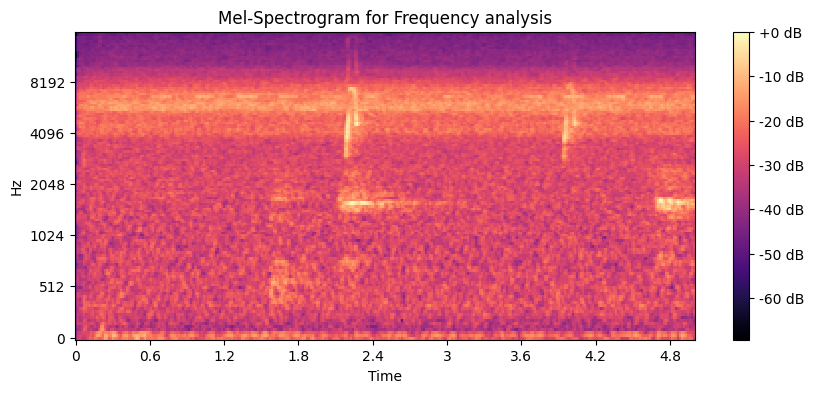

In [1]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

# Load the unzipped train_metadata.csv file
train_metadata = pd.read_csv('/kaggle/input/birdclef-2021/train_metadata.csv')

# Load the other CSV files provided by the user
soundscape_labels = pd.read_csv('/kaggle/input/birdclef-2021/train_soundscape_labels.csv')
test_data = pd.read_csv('/kaggle/input/birdclef-2021/test.csv')
sample_submission = pd.read_csv('/kaggle/input/birdclef-2021/sample_submission.csv')

# Define the base path to the audio files directory
audio_base_dir = '/kaggle/input/birdclef-2021/train_short_audio'

# Function to load and process audio files into mel-spectrograms
def process_audio_file(species, filename, sr=32000, duration=5):
    # Construct the full file path
    file_path = os.path.join(audio_base_dir, species, filename)
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Example: Process a single audio file from the training set
# You need to extract both the species folder name and the filename from the metadata
sample_species = train_metadata['primary_label'].iloc[0]
sample_audio_file = train_metadata['filename'].iloc[0]

mel_spec = process_audio_file(sample_species, sample_audio_file)
print("Mel-Spectrogram shape:", mel_spec.shape)

# Display the mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=32000, x_axis='time', y_axis='mel')
plt.title('Mel-Spectrogram for Frequency analysis')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [2]:
import os

# Define the base directory where the audio files are stored
audio_base_dir = '/kaggle/input/birdclef-2021/train_short_audio'

# Count the total number of files
total_files = sum(len(files) for _, _, files in os.walk(audio_base_dir))
print(f"Total number of audio files: {total_files}")


Total number of audio files: 62874


In [3]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import numpy as np
import os
import librosa

# Assuming train_metadata is already loaded

# Step 1: Encode the labels (bird species) into integers
label_encoder = LabelEncoder()
train_metadata['label_encoded'] = label_encoder.fit_transform(train_metadata['primary_label'])

# Select the first 10,000 files for training
train_metadata_subset = train_metadata.iloc[:1000]

# Track which species (folders) are being processed
processed_species = set()

# Function to process a single audio file into a mel-spectrogram
def process_audio_file(species, filename, sr=32000, duration=5):
    file_path = os.path.join(audio_base_dir, species, filename)
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

# Prepare the dataset: Process the selected files and create corresponding labels
def prepare_dataset(metadata, sr=32000, duration=5):
    X = []
    y = []
    # Use tqdm for progress bar
    for i, row in tqdm(metadata.iterrows(), total=len(metadata)):
        species = row['primary_label']
        filename = row['filename']
        processed_species.add(species)  # Track species being processed
        try:
            mel_spec = process_audio_file(species, filename, sr=sr, duration=duration)
            mel_spec = np.expand_dims(mel_spec, axis=-1)  # Add channel dimension for CNN input
            X.append(mel_spec)
            y.append(row['label_encoded'])
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    
    return np.array(X), np.array(y)

# Use tf.data to optimize the data pipeline
def create_tf_dataset(X, y, batch_size=32, buffer_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Step 2: Prepare the dataset with a progress bar
X, y = prepare_dataset(train_metadata_subset)

# Step 3: Convert labels to categorical (one-hot encoding)
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Step 4: Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create TensorFlow datasets for training and validation
train_dataset = create_tf_dataset(X_train, y_train)
val_dataset = create_tf_dataset(X_val, y_val)

# Output the folders (species) that have been trained
print("Folders (species) that have been trained on:")
print(sorted(processed_species))


2024-08-01 11:26:01.417325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-01 11:26:01.417444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-01 11:26:01.543703: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


Folders (species) that have been trained on:
['acafly', 'acowoo', 'aldfly', 'ameavo', 'amecro', 'amegfi']


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

# Expand the single channel to three channels
X_train_expanded = np.repeat(X_train, 3, axis=-1)
X_val_expanded = np.repeat(X_val, 3, axis=-1)

# Improved Model using ResNet50 as base
def build_improved_model(input_shape, num_classes):
    # Use ResNet50 as a base model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the input shape and number of classes based on the expanded dataset
input_shape = X_train_expanded.shape[1:]  # Use the shape of the training data
num_classes = y_train.shape[1]

# Build the improved model
model = build_improved_model(input_shape, num_classes)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 313,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 319,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 157,   │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 157,   │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 157,   │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 159,   │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 79,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 79,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 79,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 79,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 79,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 79,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 79,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 79,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 79,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 79,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 79,    │      1,024 │ conv2_block1_3_c

 Total params: 24,214,285 (92.37 MB)

 Trainable params: 626,573 (2.39 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Fit the model using the data generator
train_generator = datagen.flow(X_train_expanded, y_train, batch_size=32)

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    train_generator,
    validation_data=(X_val_expanded, y_val),
    epochs=20,
    callbacks=[reduce_lr],
    verbose=1
)

# Save the trained model in the SavedModel format
model.save('/kaggle/working/bird_sound_recognition_model.h5')

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/25 ━━━━━━━━━━━━━━━━━━━━ 8:39 22s/step - accuracy: 0.0000e+00 - loss: 6.1698

I0000 00:00:1722511685.346486     130 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722511685.406454     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.2586 - loss: 3.3452

W0000 00:00:1722511695.486171     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 637ms/step - accuracy: 0.2624 - loss: 3.3067 - val_accuracy: 0.5500 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1722511700.747106     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.4857 - loss: 1.3938 - val_accuracy: 0.7100 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.6102 - loss: 1.0535 - val_accuracy: 0.7250 - val_loss: 0.7200 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.6641 - loss: 0.9261 - val_accuracy: 0.7250 - val_loss: 0.7332 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.6880 - loss: 0.9146 - val_accuracy: 0.7350 - val_loss: 0.6721 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.6681 - loss: 0.9300 - val_accuracy: 0.7300 - val_loss: 0.6715 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.7002 - loss: 0.8109 - val_accuracy: 0.7300 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.6994 - loss: 0.8140 - val_accura

In [6]:
import tensorflow as tf
import numpy as np

# Load the saved model
print("Loading the trained model...")
model = tf.keras.models.load_model('/kaggle/working/bird_sound_recognition_model.h5')
print("Model loaded successfully.")

# Make predictions on the validation set
print("Making predictions on the validation set...")
predictions = model.predict(X_val_expanded)
print("Predictions completed.")

# Convert predictions to class labels
predicted_classes = tf.argmax(predictions, axis=1).numpy()
true_classes = tf.argmax(y_val, axis=1).numpy()

# Save predicted and true classes for further use
np.save('/kaggle/working/predicted_classes.npy', predicted_classes)
np.save('/kaggle/working/true_classes.npy', true_classes)
print("Predicted and true classes saved.")


Loading the trained model...
Model loaded successfully.
Making predictions on the validation set...
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

W0000 00:00:1722511953.036889     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 699ms/step
Predictions completed.
Predicted and true classes saved.


W0000 00:00:1722511957.234284     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Validation Accuracy: 80.00%


<Figure size 1200x800 with 0 Axes>

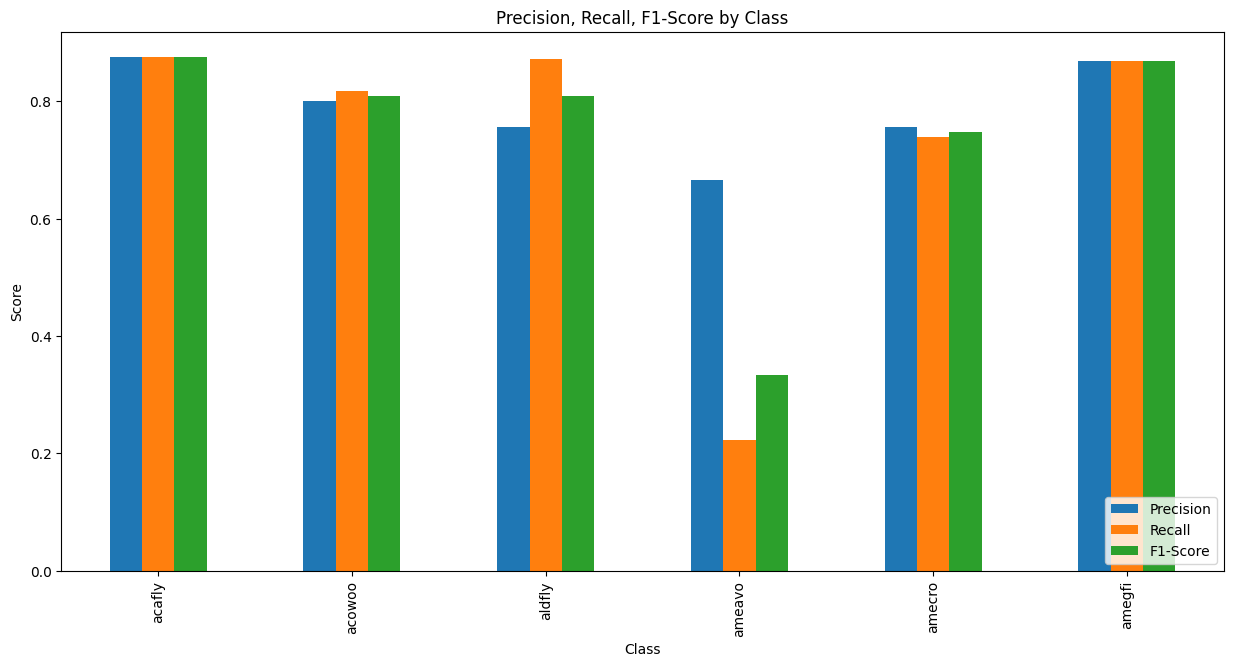

<Figure size 640x480 with 0 Axes>

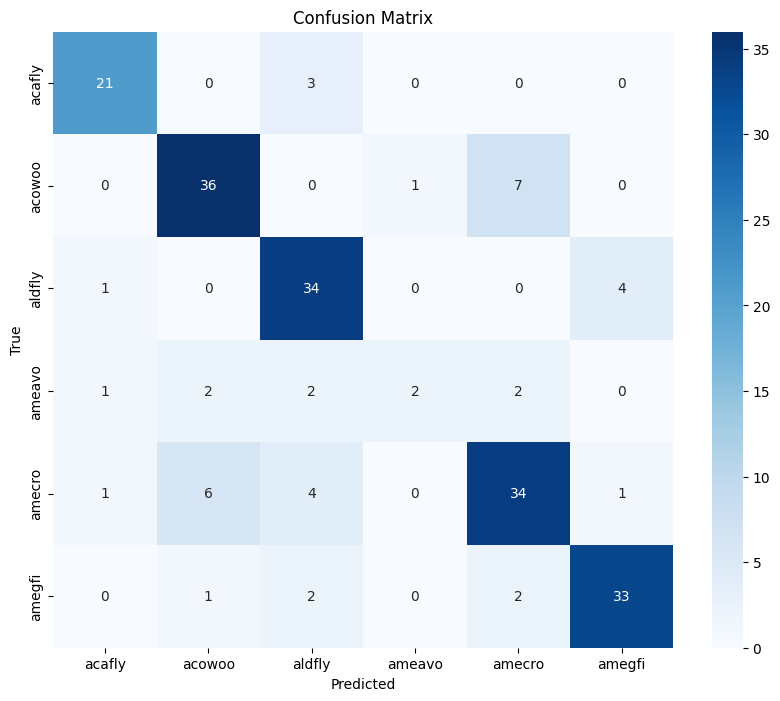

<Figure size 640x480 with 0 Axes>

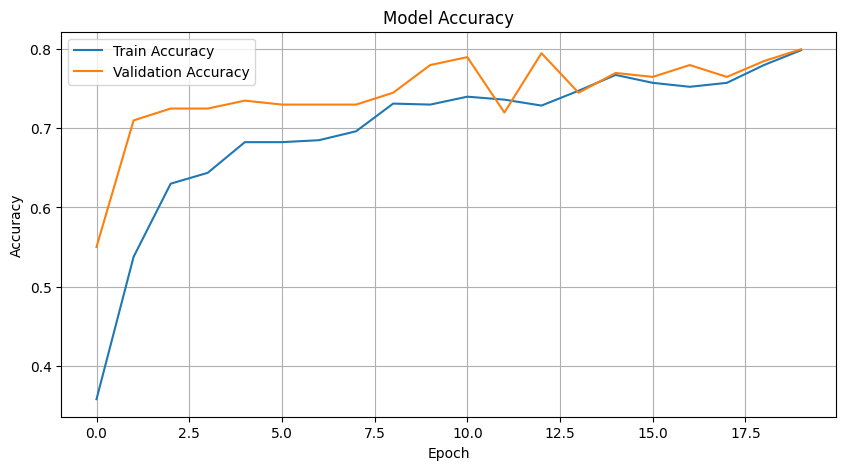

<Figure size 640x480 with 0 Axes>

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load predicted and true classes
predicted_classes = np.load('/kaggle/working/predicted_classes.npy')
true_classes = np.load('/kaggle/working/true_classes.npy')

# Get the list of classes that were actually used in training
trained_classes = label_encoder.inverse_transform(sorted(set(true_classes)))

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Generate detailed metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average=None)

# Convert to DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': trained_classes,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

# Plot Precision, Recall, and F1-Score
plt.figure(figsize=(12, 8))
metrics_df.plot(kind='bar', x='Class', stacked=False, figsize=(15, 7))
plt.title('Precision, Recall, F1-Score by Class')
plt.ylabel('Score')
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show()
plt.savefig('/kaggle/working/Scores.png')


# Generate and plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=trained_classes, yticklabels=trained_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('/kaggle/working/Confusion_Matrix.png')

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
plt.savefig('/kaggle/working/model_accuracy.png')


### Preprocessing and Output

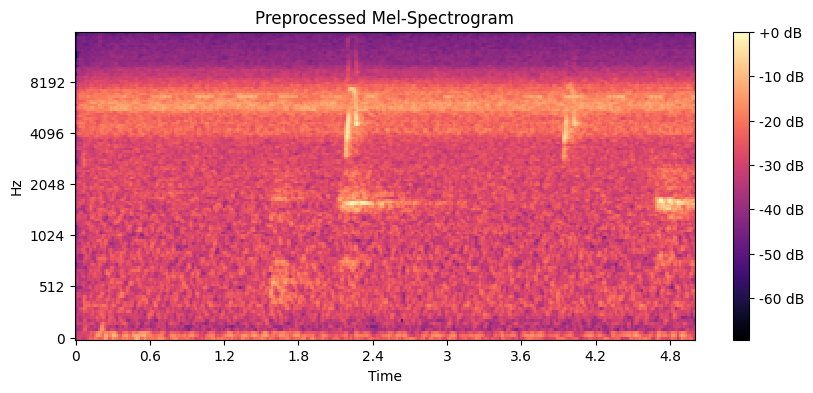

In [8]:
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

def preprocess_audio_file(file_path, sr=32000, duration=5):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=sr, duration=duration)
    # Convert to mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    # Expand dimensions to fit the model input
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dimension for CNN input
    mel_spec_db = np.repeat(mel_spec_db, 3, axis=-1)    # Convert to 3 channels for ResNet50

    return mel_spec_db

# Preprocess the given audio file
file_path = '/kaggle/input/birdclef-2021/train_short_audio/acafly/XC109605.ogg'
preprocessed_audio = preprocess_audio_file(file_path)

# Display the preprocessed mel-spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(preprocessed_audio[:, :, 0], sr=32000, x_axis='time', y_axis='mel')
plt.title('Preprocessed Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()


In [9]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('/kaggle/working/bird_sound_recognition_model.h5')

def predict_bird_species(file_path):
    # Preprocess the audio file
    mel_spec = preprocess_audio_file(file_path)
    mel_spec = np.expand_dims(mel_spec, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(mel_spec)
    predicted_class = np.argmax(prediction, axis=1)

    # Convert the predicted class to the bird species name
    bird_species = label_encoder.inverse_transform(predicted_class)[0]

    return bird_species

# Use the function to predict the bird species for the given audio file
predicted_bird = predict_bird_species(file_path)
print(f"The predicted bird species is: {predicted_bird}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
The predicted bird species is: acafly


In [11]:
import shutil

# Path to the directory you want to download
directory_to_zip = '/kaggle/working/'

# Path for the output zip file
output_zip = '/kaggle/working/working_directory.zip'

# Create a zip file of the directory
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', directory_to_zip)

print(f"Created zip file: {output_zip}")


Created zip file: /kaggle/working/working_directory.zip
